# Model selection using hyperopt

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def plot_data(X_train, X_test, y_train, y_test, h=0.02):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    fig, ax = plt.subplots()

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    return fig, ax

# Show the decision surface of the optimal classifier
def plot_clf(X_train, X_test, y_train, y_test, clf, h=0.02):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    fig, ax = plt.subplots()

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

## Create an artificial data set

(<matplotlib.figure.Figure at 0x106e4fd68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x106e4b438>)

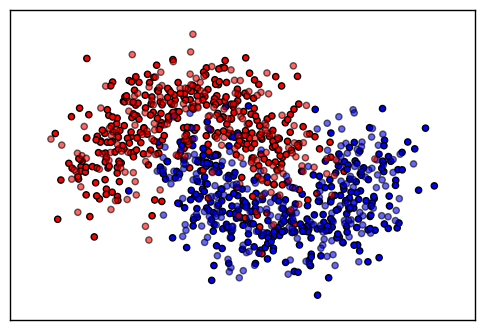

In [2]:
X, y = make_moons(n_samples=1000, noise=0.3, random_state=0)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

plot_data(X_train, X_test, y_train, y_test)

In [3]:
from hyperopt import hp, fmin, rand, tpe, Trials, STATUS_FAIL, STATUS_OK
from hyperopt.pyll import scope

scope.define(KNeighborsClassifier)
scope.define(SVC)
scope.define(GaussianProcessClassifier)

sklearn.gaussian_process.gpc.GaussianProcessClassifier

## Define search space

In [4]:
C = hp.loguniform('svc_c', -4, 1)
search_space = hp.pchoice('estimator', [
    (0.1, scope.KNeighborsClassifier(n_neighbors=1 + hp.randint('n_neighbors', 9))),
    (0.1, scope.SVC(kernel='linear', C=C)),
    (0.4, scope.SVC(kernel='rbf', C=C, gamma=hp.loguniform('svc_gamma', -4, 1))),
    (0.4, scope.GaussianProcessClassifier(kernel=hp.choice('gp_kernel', [RBF(), Matern(nu=1.5), Matern(nu=2.5)])))
])

# Create logger using the Trials object supplied by hyperopt
trials = Trials()

def objective_function(estimator):
    estimator.fit(X_train, y_train)
    
    y_hat = estimator.predict(X_test)
    return -1 * accuracy_score(y_test, y_hat)

In [5]:
# Call fmin
best = fmin(
    fn=objective_function,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50
)
print(best)

{'svc_gamma': 2.357247846608504, 'svc_c': 2.0908911442998437, 'estimator': 2}


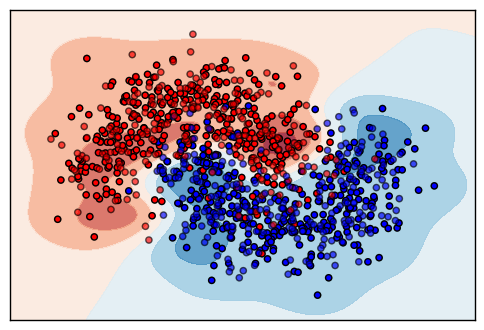

In [6]:
clf = SVC(kernel='rbf', gamma=2.357247846608504, C=2.0908911442998437, probability=True)
clf.fit(X_train, y_train)

plot_clf(X_train, X_test, y_train, y_test, clf)